# Bayesian estimation of errors for redshift-independent distance measurements in the NED-D catalog

In [693]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as op
from scipy import stats
import emcee
import corner
from scipy.stats import chisquare
%matplotlib inline

In [2]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [3]:
# Not necessary, this is only used for "un-biasing" standard deviation estimations
def c4(em):
    return np.sqrt(2/(em-1.))*gamma(em/2.)/gamma((em-1.)/2)

#### Filtering

Here we apply filters to the data. We are interested in NED-D sources which do not show redshift data. The reason is that in the tabulated version of NED-D, reported redshifts are calculated using the distance modulus, and have not been measured directly.

In [4]:
df=pd.read_csv("NED26.05.1-D-12.1.0-20160501.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])]
df=df[df['D (Mpc)']<500]
df=df[np.isfinite(df.err)]
df=df[df['D (Mpc)']>35]

In [5]:
df.shape

(54398, 15)

In [6]:
df.head()

,Exclusion Code,D,G,Galaxy ID,m-M,err,D (Mpc),Method,REFCODE,SN ID,redshift (z),Hubble const.,Adopted LMC modulus,Date (Yr. - 1980),Notes
4,NaN,3,2,UGC 12889,34.16,0.40,68.0,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,mean
5,NaN,4,2,UGC 12889,34.66,0.45,85.6,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,K
6,NaN,5,2,UGC 12889,34.68,0.47,86.1,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,H
7,NaN,6,2,UGC 12889,34.70,0.46,86.9,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,J
8,NaN,7,3,KUG 2357+228,33.52,0.20,50.6,Tully-Fisher,2013AJ....146...86T,NaN,NaN,74.4,NaN,33,NaN


We select individual methods, as our models will be method-dependent. I think our model works best for methods with a large number of reported measurements.

In [7]:
for i in np.unique(df.Method):
    df1=df[df.Method==i]
    print i,df1.shape

AGN time lag (24, 15)
Black Hole (12, 15)
CMD (3, 15)
Cepheids (4, 15)
D-Sigma (815, 15)
Dwarf Galaxy Diameter (6, 15)
FP (11038, 15)
Faber-Jackson (527, 15)
GCLF (36, 15)
GeV TeV ratio (3, 15)
H I + optical distribution (1, 15)
HII region diameter (1, 15)
IRAS (2089, 15)
Maser (6, 15)
Ring Diameter (71, 15)
SBF (236, 15)
SGRB (5, 15)
SNII optical (319, 15)
SNII radio (6, 15)
SNIa (1988, 15)
SZ effect (5, 15)
Sosies (129, 15)
Tertiary (92, 15)
Tully est (264, 15)
Tully-Fisher (36718, 15)


In [8]:
np.unique(df1.Method)

array(['Tully-Fisher'], dtype=object)

In [10]:
# Select a method, here we choose Tully-Fisher (the last method selected in the previous cells)
listcut=np.unique(df1['Galaxy ID'])
listcut

array(['2MASX J00024069+0846251', '2MASX J00041398-5113247',
       '2MASX J00062236-5010027', ..., 'WISEP J041245.99+294612.5',
       'WKK 2029', 'ZwCl 1115.2+3013 03'], dtype=object)

## Gaussian Mixture Model (GMM) fitting of measurement errors

We consider that each individual measurement of a distance modulus and a distance modulus error can be represented by a gaussian, meaning that the distance modulus error comes from random statistical fluctuations. However, given that the relation between the distance and distance modulus is logarithmic, the distance distribution is not gaussian. For this reason, we generate a gaussian dataset for the distance modulus, which is then transformed to a distance dataset (which is not gaussian). 

After measuring the distance modulus many times, the distance distribution becomes gaussian. We model this using a Gaussian Mixture Model (GMM), which is a (bayesian) probabilistic model that finds the best values for the centroid and variance of a single gaussian distribution encompassing all the distance (measurement) distributions for each galaxy. We call these values $D_E$ (estimated distance) and $\sigma_E$, estimated error.

We also find the average reported distance and distance error (from error propagation of the reported distance modulus error), which we call $\bar{D}$ and $\bar{\Delta}$, and the corresponding 16%, 50%, and 84% (percentile) values of the combined distributions (not the GMM model). 

In [12]:
# reported distance error from error propagation of the reported distance modulus error for each measurement
disterr=0.461*df1['D (Mpc)']*df1.err 

In [14]:
import sklearn.mixture
gmm = sklearn.mixture.GMM()

In [1641]:
%%time
errlist=np.zeros((len(listcut),8))
k=0
ncutoff=10
nbins=1000 # resolution for the generated distributions
for i in listcut:
    dfilter=(df1['Galaxy ID']==i)
    if(len(df1[dfilter])>ncutoff): # Select galaxies which have more than n measurements
        data=np.array([])
        dummy=df1[dfilter]
        for i in dummy.D:
            otherfilter=(dummy.D==i)
            # generate distance distribution for each distance modulus/ distance modulus error measurement
            AA=10**(np.random.normal(dummy['m-M'][otherfilter],dummy['err'][otherfilter],nbins)/5.+1)
            data=np.hstack((data,AA))            
        dumerr=disterr[dfilter]
        em=len(df1[dfilter])
        r = gmm.fit(data[:, np.newaxis])
        # Distances in Mpc
        errlist[k,0]=r.means_[0, 0]/1e6 # Centroid of the GMM-fitted distribution
        errlist[k,1]=em # Number of measurements for each galaxy
        errlist[k,2]=np.sqrt(r.covars_[0, 0])/1e6 # Variance of the GMM-fitted distribution
        errlist[k,3]=np.percentile(data, 50)/1e6 # Percentiles of the combined distance distributions (50, 84, 16):
        errlist[k,4]=np.percentile(data, 84)/1e6-errlist[k,3]
        errlist[k,5]=errlist[k,3]-np.percentile(data, 16)/1e6
        errlist[k,6]=dumerr.mean() # average reported error (Delta)
        errlist[k,7]=dummy['D (Mpc)'].mean() # average reported distance (D)
    k+=1


CPU times: user 26 s, sys: 4 ms, total: 26 s
Wall time: 26 s


In [1642]:
(errlist[:,0]!=0).sum() # number of galaxies left after filtering

565

In [1310]:
filter=(errlist[:,0][(errlist[:,0]!=0)]<500) # additional filter, not really necessary

In [1643]:
# we quickly define the log-likelihood for a linear model, we use it here only to find a good linear fit
# this is only for visually comparing variables, this is not used later
def lnlike(theta, x, y):
    m ,b = theta
    model = m * x +b
    inv_sigma2 = 1.0/((y)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))


In [ ]:
def lnprior(theta):
    m, b = theta
    if 0 < m < 1 and -5 < b < 5:
        return 0.0
    return -np.inf
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

The centroid for the GMM-fit ($D_E$) and the reported mean distance ($\bar{D}$) correlate very well. However, we will use $D_E$ from now on (we don't trust the reported mean).

0.984254228723 -0.0667375057043


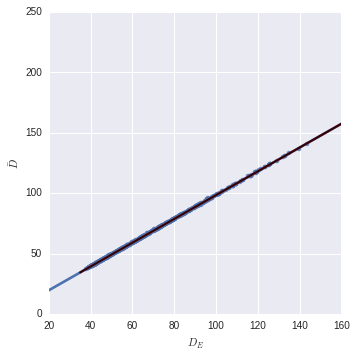

In [1666]:
# gmm-fitted mean vs. unweighted mean
x=errlist[(errlist[:,0]!=0)][:,0]
y=errlist[(errlist[:,0]!=0)][:,7]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
# OLS fit
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(y * y)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
# ML fit
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls], args=(x, y))
m_ml, b_ml= result["x"]
print m_ml,b_ml
xl = np.array([35, 200])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="k", lw=2, alpha=0.8)
#aaa=200
#plt.plot(range(aaa),range(aaa),c='r')
plt.xlabel(r"$D_E$")
plt.ylabel(r"$\bar{D}$")

#plt.ylim(0,aaa)

The 50% percentile values for the distance distributions correlate well with the fitted centroids.

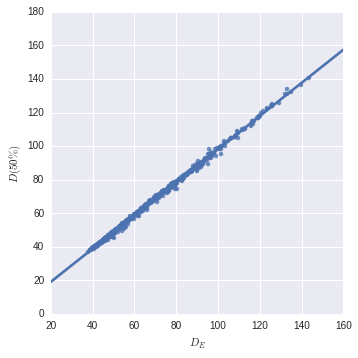

In [1667]:
# weighted vs. 50% percentile
x=errlist[(errlist[:,0]!=0)][:,0]
y=errlist[(errlist[:,0]!=0)][:,3]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
#aaa=200
#plt.plot(range(aaa),range(aaa),c='r')
plt.xlabel(r"$D_E$")
plt.ylabel(r"$D (50\%)$")

There is a strong correlation between the fitted centroid and fitted variances, and the OLS fit slightly differs from the ML fit. We also notice that every fitted variance is larger than its corresponding mean reported error.

0.200047517442 0.627757004284


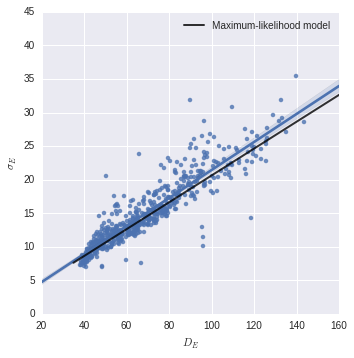

In [1801]:
# gmm-fitted sigma
x=errlist[(errlist[:,0]!=0)][:,0]
y=errlist[(errlist[:,0]!=0)][:,2]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(y * y)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls], args=(x, y))
m_ml, b_ml= result["x"]
print m_ml,b_ml
xl = np.array([35, 200])
plt.plot(xl, m_ls*xl+b_ls, color="k", lw=2, alpha=0.8,label="Maximum-likelihood model")
plt.xlabel(r"$D_E$")
plt.ylabel(r"$\sigma_E$")
plt.legend()

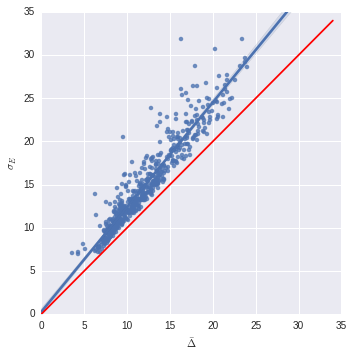

In [1800]:
# gmm-fitted sigma vs reported error
x=errlist[(errlist[:,0]!=0)][:,6]
y=errlist[(errlist[:,0]!=0)][:,2]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
aaa=35
plt.plot(range(aaa),range(aaa),c='r')
plt.xlim(0,aaa)
plt.ylim(0,aaa)
plt.xlabel(r"$\bar{\Delta}$")
plt.ylabel(r"$\sigma_E$")

## Bayesian modelling

Now we will try to create a bayesian model that consistently and robustly predicts $\sigma_E$ from $D_E$ and $\bar{\Delta}$. Our predictive model will be built around the posterior distribution for the parameter estimators in the following equation:

$$\sigma_\mathrm{sim}(D_E,\bar{\Delta})=n\ D_E^2+m\ D_E+b+f\ \bar{\Delta}$$

We estimate this distribution by using the `emcee` Monte Carlo Markov Chain (MCMC) sampler to maximize our log-probability, which is calculated from the likelihood and the prior probabilities for the estimators $\Theta=(n,m,b,f)$. We use uniformative (uniform) priors for the estimators. See the `emcee` docs for more details (http://dan.iel.fm/emcee/current/user/line/).

In [1674]:
filter=(errlist[:,0][(errlist[:,0]!=0)]>0)
x=errlist[(errlist[:,0]!=0)][:,0][filter]
y=errlist[(errlist[:,0]!=0)][:,2][filter]
yerr=errlist[(errlist[:,0]!=0)][:,6][filter]
# yerr=y_me[filter] just in case you want to try an iteratively convergent model ... not required at this point

In [1675]:
# Likelihood
def lnlike(theta, x, y,yerr):
    m ,b,n,f = theta
    model = m * x +b+n*x**2+f*yerr # model equation
    inv_sigma2 = 1.0/((y)**2) # weighted by the GMM-fitted sigma
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2))) 
# Priors
def lnprior(theta):
    m, b,n,f = theta
    if -1 < m < 1 and -30 < b < 30 and -10<n<10 and -10<f<10:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob(theta, x, y,yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr)

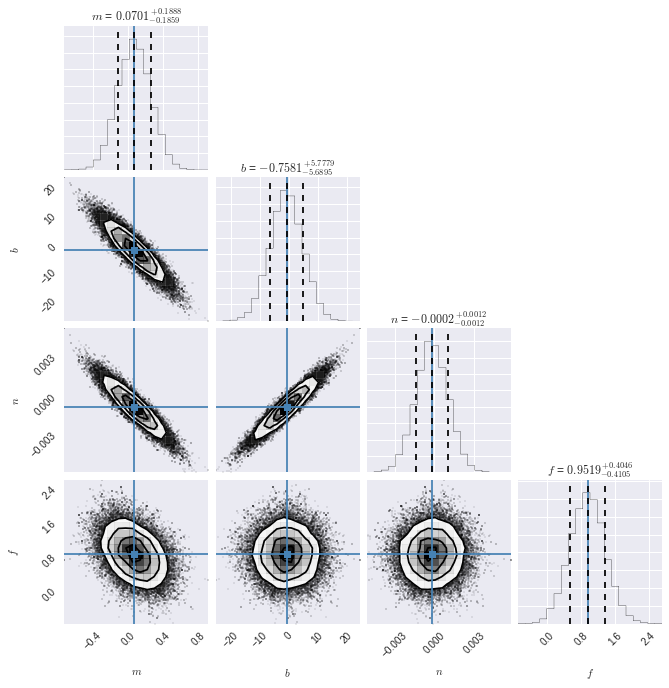

In [1766]:
# This block uses the emcee MCMC sampler to estimate the posterior probability
# 1. Guess the starting places for the walkers from a maximum likelihood fit
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [1, 1,1,1], args=(x, y,yerr))
m_ml, b_ml,n_ml,f_ml= result["x"]
ndim, nwalkers = 4, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y,yerr)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
# When needed, we use the mean of the posterior for each parameter
# The mean is an unbiased estimator for the best values of the model parameters
meanest=samples.mean(axis=0) 
# 3. Corner plot! Shows the marginalized distribution for our parameter space
fig = corner.corner(samples, labels=["$m$", "$b$","$n$","$f$"],
                      truths=[meanest[0], meanest[1],meanest[2],meanest[3]], quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

### (Bayesian) Goodness-of-fit

Is our model good? Let's try looking at a set of simulated (synthetic) data generated from our posterior predictive. We expect that the simulated errors $\sigma_E^\mathrm{sim}$ (red dots) look similar to the observed (GMM-fitted) errors $\sigma_E^\mathrm{obs}$ (blue dots). The yellow dots are the expected $\sigma_E$ values for the posterior predictive distribution. The green dots represent the ML-obtained model $\sigma_E$ values, which coincide with the expected values.

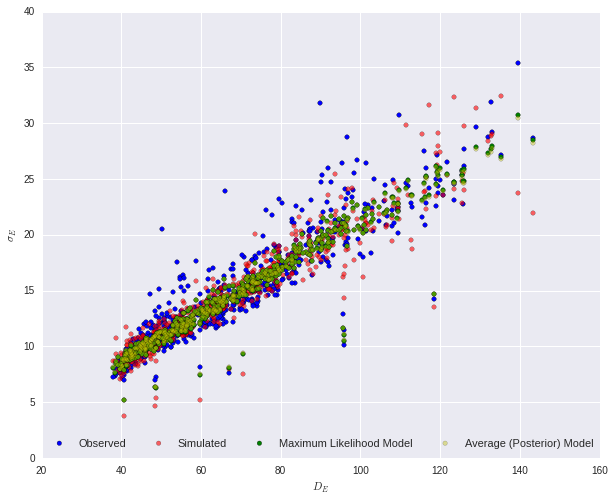

In [1684]:
plt.figure(figsize=(10,8))

plobs = plt.scatter(x,y)
AAA=samples[np.random.randint(len(samples), size=len(x))]
y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*x**2+AAA[:,3]*yerr
plsim = plt.scatter(x,y_sim,c='r',alpha=0.6)
y_ml=m_ml*x+b_ml+n_ml*x**2+f_ml*yerr
y_me=meanest[0]*x+meanest[1]+meanest[2]*x**2+meanest[3]*yerr
plml = plt.scatter(x,y_ml,c='g')
plme = plt.scatter(x,y_me,c='y',alpha=0.4)
plt.xlabel(r"$D_E$")
plt.ylabel(r"$\sigma_E$")
plt.legend((plobs, plsim, plml, plme),
           ('Observed', 'Simulated', 'Maximum Likelihood Model', 'Average (Posterior) Model'),
           scatterpoints=1,
           loc='lower center',
           ncol=4,
           fontsize=11)

plt.show()

#### Fisher's method for meta-analysis of Kolmogorov-Smirnov p-values

It looks good, but is it possible to say that the observed and synthetic data come from the same distribution? The answer to this is no, unfortunately. However, we can try to test whether they do *not* come from the same distribution. The two-sample Kolmogorov-Smirnov test can compare the Empirical Cumulative Distribution Function (ECDF) of two samples and yield a p-value for the null hypothesis (that they do come from the same distribution). If the KS p-value is too low ($p<0.05$), we can reject the null hypothesis (i.e. we can say that they do not come from the same distribution).

What we are looking for here is that the KS test results do not reject the null hypothesis (i.e. we cannot reject the hypothesis that the synthetic and observed data come from the same distribution). Me should keep in mind that running the test once is meaningless, as every set of synthetic data will be different. For this reason, we should run the test many times and see how the p-values behave. 

What behavior are we looking for here? This is not a simple question. Me need to combine the resulting p-values in a meaningful way. This can be done using Fisher's method:

$$\chi^2\sim-2\sum_i \log(p_i) $$

From Wikipedia:

> Fisher's method combines extreme value probabilities from each test, commonly known as "p-values", into one test statistic [ ]. When the p-values tend to be small, the test statistic will be large, which suggests that the null hypotheses are not true for every test.

> When all the null hypotheses are true, and the $p_i$ (or their corresponding test statistics) are independent, [the combined p-values statistic] has a chi-squared distribution with 2k degrees of freedom, where k is the number of tests being combined. This fact can be used to determine the p-value for [the combined p-values statistic].

> The distribution is a chi-squared distribution for the following reason; under the null hypothesis for test i, the p-value $p_i$ follows a uniform distribution on the interval [0,1]. The negative natural logarithm of a uniformly distributed value follows an exponential distribution. Scaling a value that follows an exponential distribution by a factor of two yields a quantity that follows a chi-squared distribution with two degrees of freedom. Finally, **the sum of k independent chi-squared values, each with two degrees of freedom, follows a chi-squared distribution with 2k degrees of freedom**.

Our meta-test consists in estimating a statistic for the combined p-values using Fisher's method and checking whether they are chi-squared distributed (t-test) considering 2k degrees of freedom. If the meta p-value is low, we cannot reject the hypothesis that synthetic errors generated from our posterior predictive can come from the same distribution as the observed (GMM-fitted) errors.

Note: We do not draw the data for the KS test from residuals, are they are meaningless in a bayesian framework.

See also:

* http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ks_2samp.html
* https://en.wikipedia.org/wiki/Fisher%27s_method

Meta-chisq-statistic: 14904.5087247 DOF: 20000
Meta p-value (should be low): 3.48999212328e-173


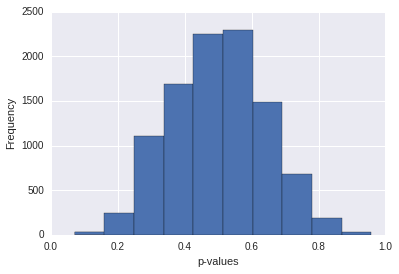

In [1697]:
listaksst=[]
listakspv=[]
rvs1 = (y)
ndsets=10000 # number of tests to run
for i in range(ndsets):
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*x**2+AAA[:,3]*yerr
    rvs3 = (y_sim)
    listaksst.append(stats.ks_2samp(rvs1, rvs3)[0])
    listakspv.append(stats.ks_2samp(rvs1, rvs3)[1]) # here are the p values
listaksst=np.asarray(listaksst)
listakspv=np.asarray(listakspv)
cpval=-2*(np.log(listakspv)).sum() # Fisher's method statistic
print "Meta-chisq-statistic:", cpval, "DOF:",2*ndsets
print "Meta p-value (should be low):", stats.chi2.cdf(cpval, 2*ndsets)
plt.hist(listakspv)
plt.xlabel("p-values")
plt.ylabel("Frequency")

#### Bayesian p-value using a Freeman-Tukey discrepancy measure

The previous test shows whether the model can generate synthetic data not unlike the observed errors. We can also test directly the posterior predictive by measuring discrepancies between (synthetic or observed) data and expected values from the posterior predictive. We can then obtain a "Bayesian" p-value from how (dis)similar the discrepancies are for many realizations from the posterior predictive (Gelman 1996).

In order to calculate a discrepancy for a given dataset {$\sigma_E$}$=${$\sigma_{E,1},\sigma_{E,2},...,\sigma_{E,N}$}, we draw a 4-tuple of parameters ($\Theta_i=n_i,m_i,b_i,f_i$) from the posterior predictive and calculate the expected values for that realization, {$\langle\sigma_E^i\rangle$}$=${$\langle\sigma_E(\Theta_i)\rangle$}. Since our dataset comes from data where the no. of samples (per galaxy) can change from data point to data point, we use the Freeman-Tukey statistic as a discrepancy measure (Brooks 2000), which unlike Pearson's chi-square discrepancy measure, does not require re-binning of data (Christensen 2011):

$$D(\sigma_E,\Theta_i)=\sum_{j=1}^N \left(\sqrt{\sigma_{E,j}}-\sqrt{\langle\sigma_E(\Theta_i)\rangle_j}\right)^2$$

For a given $\langle\sigma_E(\Theta_i)\rangle$, we (independently from $\Theta_i$) generate a synthetic dataset from the posterior predictive and calculate the synthetic discrepancy $D(\sigma_E^{\mathrm{sim}},\Theta_i)$ and the observed discrepancy $D(\sigma_E^{\mathrm{obs}},\Theta_i)$. After doing this many times, we expect that if the model and data are not inconsistent, on average the observed and synthetic discrepancies will be very similar. We can define then a bayesian p-value from the proportion in which the simulated discrepancies are larger than the observed discrepancies for a large number of realizations (Gelman 1996). This means that if (the model is not inconsistent with the observed data and) we plot simulated vs. observed discrepancies, a 45$^\circ$ line will pass through a significant number of realizations. Thus, p-values which are too low or too high ($p< 0.025$ or $p> 0.975$) will then indicate inconsistency.

See also:
* https://books.google.com.co/books/about/Bayesian_Analysis_for_Population_Ecology.html?id=KmvwAAAAMAAJ&redir_esc=y
* https://pymc-devs.github.io/pymc/modelchecking.html
* Brooks et al (2000) https://www.jstor.org/stable/2676830?seq=1#page_scan_tab_contents
* Gelman et al (1996) http://www.stat.columbia.edu/~gelman/research/published/A6n41.pdf
* Chapter 4 of Christensen et al (2011) https://books.google.com.co/books?id=qPERhCbePNcC

Bayesian p-value: 0.05306
Rejection rate (%): 2.444


(0, 200)

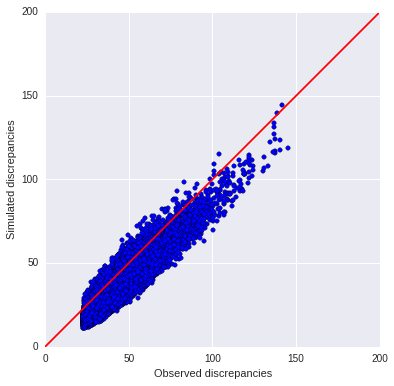

In [1710]:
discobs=[]
discsim=[]
nrealiz=50000
for m,b,n,f in samples[np.random.randint(len(samples), size=nrealiz)]: # draw Theta_i from posterior predictive, do this 5000 times
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*x**2+AAA[:,3]*yerr # create a synthetic dataset
    yexp=m*x+b+n*x**2+f*yerr # calculate expected values from Theta_i
# Calculate discrepancies using the Freeman-Tukey statistic
    discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
    discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)
plt.figure(figsize=(6,6))
plt.scatter(discobs,discsim)
print "Bayesian p-value:", (discobs<discsim).sum()*1./len(discobs)
# the model sometimes predicts negative values for errors, such datasets are rejected:
print "Rejection rate (%):", np.isnan(discsim).sum()*100./len(discsim) 
ppp=np.arange(200)
plt.plot(ppp,ppp,c='r')
plt.xlabel("Observed discrepancies")
plt.ylabel("Simulated discrepancies")
plt.xlim(0,200)
plt.ylim(0,200)

In [1759]:
negsim=[]
for m, b, n, f in samples[np.random.randint(len(samples), size=5000)]:
    negsim.append((m*xl+b+n*x**2+f*yerrl<0).sum()*100./len(x))
negsim=np.asarray(negsim)
print "Av. percentage of times a negative value will appear in a synthetic dataset:", negsim[negsim!=0].mean()

Av. percentage of times a negative value will appear in a synthetic dataset: 4.17404796276


#### MCMC chain convergence

The autocorrelation "time" is a good measure of whether the MCMC walkers are converging to the "true" region of interest in $\Theta$-parameter space. The first, uncorrelated walker steps appear in the so-called "burn-in" phase, which is cut from the posterior sampling (as mentioned above). In our case we need around 10000 steps in order to properly estimate the autocorrelation "time", although our model is strong enough at 1000 steps. We cut at 100 steps, which according to the autocorrelation "time" for each parameter seems to be a good value (average is around 50).

46.4715649748 12.1217940115
47.7825237768 13.896615556
46.9582503216 11.6803228856
45.7852097757 12.397349561


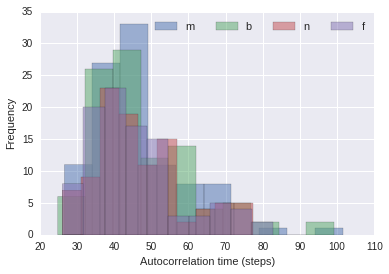

In [1718]:
for j in range(4):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print autocorr.mean(),autocorr.std()
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ['m','b','n','f'],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

#### Frequentist goodness-of-fit

Full disclosure: does the frequentist (best-parameters-model according to the posterior predictive) model show good correlation with the observed data? We run a chi-square t-test to check. If the p-value is high, we have good correlation.

In [1723]:
observed_values=y
expected_values=y_me
chisquare(f_obs=observed_values, f_exp=expected_values)

Power_divergenceResult(statistic=103.44275016647468, pvalue=1.0)

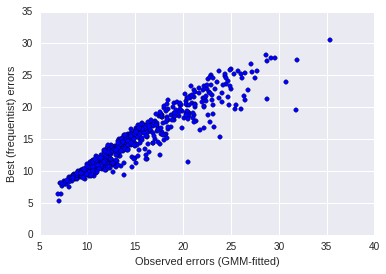

In [1724]:
plt.scatter(observed_values,expected_values)
plt.xlabel("Observed errors (GMM-fitted)")
plt.ylabel("Best (frequentist) errors")

#### Model visualization

What does the distribution of models look like? Do we manage to get predicted errors larger than the mean reported errors?

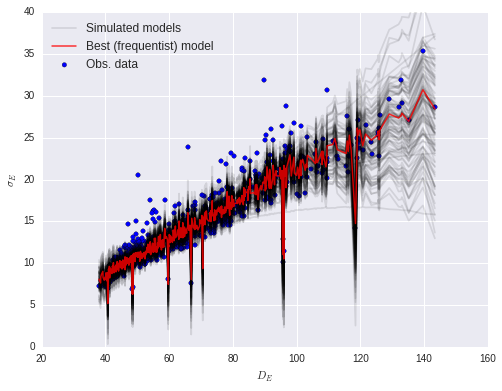

In [1745]:
plt.figure(figsize=(8,6))
xl, yerrl = (list(x) for x in zip(*sorted(zip(x, yerr))))
xl,yerrl=np.asarray(xl),np.asarray(yerrl)
for m, b, n, f in samples[np.random.randint(len(samples), size=100)]: # Draw model "lines" from posterior predictive
    plt.plot(xl, m*xl+b+n*xl**2+f*yerrl, color="k", alpha=0.1)
plt.plot(xl, m*xl+b+n*xl**2+f*yerrl, color="k", alpha=0.1,label="Simulated models")
plt.plot(xl, meanest[0]*xl+meanest[1]+meanest[2]*xl**2+meanest[3]*yerrl, color="r", lw=1.5, alpha=0.8,label="Best (frequentist) model")
plt.scatter(x,y,label="Obs. data")
plt.ylim(0,40)
plt.xlabel(r"$D_E$")
plt.ylabel(r"$\sigma_E$")
plt.legend(loc='upper left',
           ncol=1,
           fontsize=12)

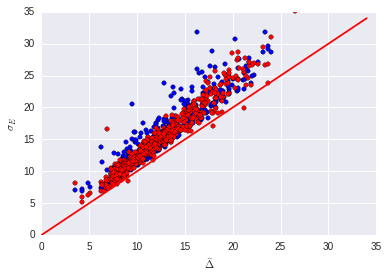

In [1765]:
# model-predicted sigma vs mean reported error
AAA=samples[np.random.randint(len(samples), size=len(x))]
xx=errlist[(errlist[:,0]!=0)][:,6][filter]
yy=errlist[(errlist[:,0]!=0)][:,2][filter]
plt.scatter(xx,yy)
plt.scatter(xx,AAA[:,0]*x+AAA[:,1]+AAA[:,2]*x**2+AAA[:,3]*yerr,c='r')
aaa=35
plt.plot(range(aaa),range(aaa),c='r')
plt.xlim(0,aaa)
plt.ylim(0,aaa)
plt.xlabel(r"$\bar{\Delta}$")
plt.ylabel(r"$\sigma_E$")

In [1507]:
# Only do this for 1000 steps in the MCMC
np.savetxt('posteriorpredictive.txt',samples)

## Predictive model

Now we need to predict errors for the rest of the galaxies (for those with less measurements).

In [1772]:
%%time
err4mod=np.zeros((len(listcut),8))
k=0
nbins=1000
for i in listcut:
    dfilter=(df1['Galaxy ID']==i)
    if 2<len(df1[dfilter])<ncutoff+1:
        data=np.array([])
        dummy=df1[dfilter]
        for i in dummy.D:
            otherfilter=(dummy.D==i)
            AA=10**(np.random.normal(dummy['m-M'][otherfilter],dummy['err'][otherfilter],nbins)/5.+1)
            data=np.hstack((data,AA))            
        dumerr=disterr[dfilter]
        em=len(df1[dfilter])
        r = gmm.fit(data[:, np.newaxis])
        err4mod[k,0]=r.means_[0, 0]/1e6
        err4mod[k,1]=em
        err4mod[k,2]=np.sqrt(r.covars_[0, 0])/1e6
        err4mod[k,3]=np.percentile(data, 50)/1e6
        err4mod[k,4]=np.percentile(data, 84)/1e6-errlist[k,3]
        err4mod[k,5]=errlist[k,3]-np.percentile(data, 16)/1e6
        err4mod[k,6]=dumerr.mean()
        err4mod[k,7]=dummy['D (Mpc)'].mean()
    k+=1


CPU times: user 57.5 s, sys: 4 ms, total: 57.5 s
Wall time: 57.5 s


In [1773]:
(err4mod[:,0]!=0).sum() # Number of galaxies with a number of measurements below the cutoff

5198

In [1774]:
filter=(err4mod[:,0][(err4mod[:,0]!=0)]<500)

(0, 120)

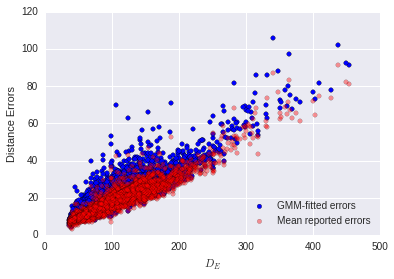

In [1786]:
# gmm-fitted sigma and mean reported errors vs. gmm-fitted centroids
xx=err4mod[(err4mod[:,0]!=0)][:,0][filter]
yy=err4mod[(err4mod[:,0]!=0)][:,2][filter]

plt.scatter(xx,yy,label="GMM-fitted errors")
plt.scatter(xx,err4mod[(err4mod[:,0]!=0)][:,6][filter],c='r',alpha=0.4,label="Mean reported errors")
plt.xlabel(r"$D_E$")
plt.ylabel("Distance Errors")
plt.legend(loc='lower right')
plt.ylim(0,120)

What will we use as $\bar{\Delta}$ for our predictive model? The mean reported errors? The GMM-fitted errors? We can't trust these too much, since the bias becomes larger as the number of measurements is smaller. We will try using them, but we will also try to predict "prior" values for them using a simple, maximum-likelihood linear model obtained from the $\bar{\Delta}$ values used in the Bayesian model above.

In [1794]:
def lnlike(theta, x, y):
    m ,b = theta
    model = m * x +b
    inv_sigma2 = 1.0/((y)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))

Is the ML linear model good (p~1)?  Power_divergenceResult(statistic=72.600707207977862, pvalue=1.0)


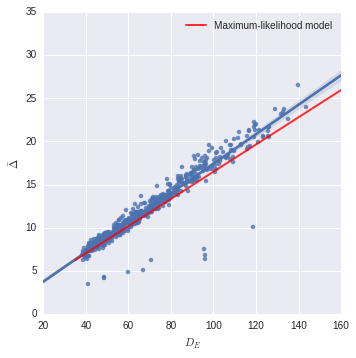

In [1805]:
x=errlist[(errlist[:,0]!=0)][:,0] # D_E
y=errlist[(errlist[:,0]!=0)][:,6] # Delta
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [1, 1], args=(x, y))
m_ml, b_ml= result["x"]
#print m_ml,b_ml
xl = np.array([35, 200])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8,label="Maximum-likelihood model")
observed_values=y
expected_values=m_ml*x+b_ml
print "Is the ML linear model good (p~1)? ",chisquare(f_obs=observed_values, f_exp=expected_values)
plt.xlabel(r"$D_E$")
plt.ylabel(r"$\bar{\Delta}$")
plt.legend()

We now compare the model predictions using different values for the input mean reported errors.

(0, 80)

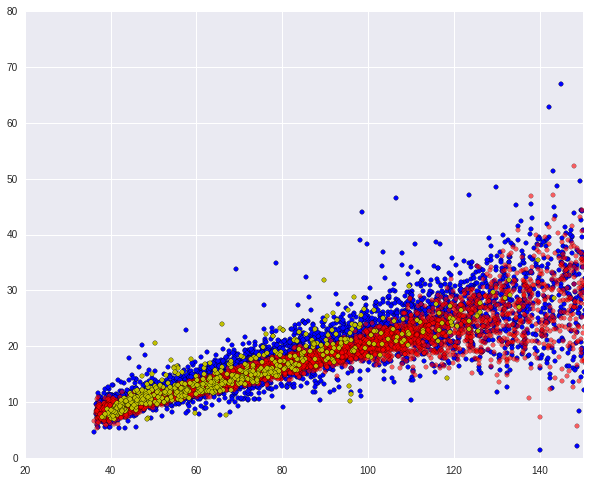

In [1807]:
plt.figure(figsize=(10,8))
x=errlist[(errlist[:,0]!=0)][:,0] # D_E
y=errlist[(errlist[:,0]!=0)][:,2] # Delta
yyerr1=err4mod[(err4mod[:,0]!=0)][:,6][filter]
yyerr2=m_ml*xx+b_ml
AAA=samples[np.random.randint(len(samples), size=len(xx))]
yy_sim1=AAA[:,0]*xx+AAA[:,1]+AAA[:,2]*xx**2+AAA[:,3]*yyerr1
yy_sim2=AAA[:,0]*xx+AAA[:,1]+AAA[:,2]*xx**2+AAA[:,3]*yyerr2

plt.scatter(xx,yy_sim1,label="")
plt.scatter(xx,yy_sim2,c='r',alpha=0.6)
#plt.scatter(xx,err4mod[(err4mod[:,0]!=0)][:,2][filter],c='k',alpha=0.4)
#plt.scatter(xx,yyerr2,c='k')
plt.scatter(x,y,c='y')
plt.xlim(20,150)
plt.ylim(0,80)

(0, 80)

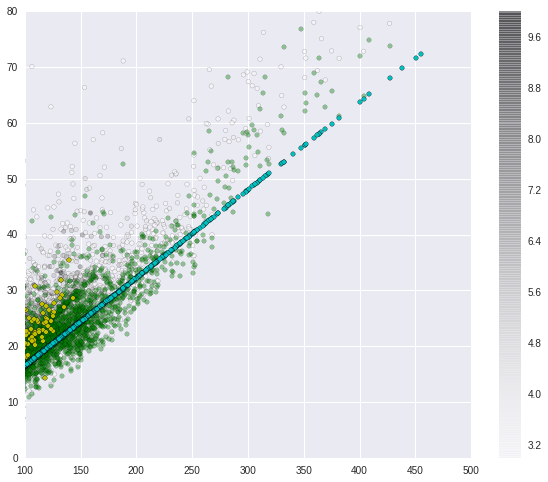

In [1808]:
filter=err4mod[(err4mod[:,0]!=0)][:,1]>2
plt.figure(figsize=(10,8))
yyerr1=err4mod[(err4mod[:,0]!=0)][:,2]
yyerr2=m_ml*xx+b_ml
AAA=samples[np.random.randint(len(samples), size=len(xx))]
yy_sim1=AAA[:,0]*xx+AAA[:,1]+AAA[:,2]*xx**2+AAA[:,3]*yyerr1
yy_sim2=AAA[:,0]*xx+AAA[:,1]+AAA[:,2]*xx**2+AAA[:,3]*yyerr2

#plt.scatter(xx,yy_sim1)
#plt.scatter(xx,yy_sim2,c='r',alpha=0.6)
plt.scatter(xx[filter],err4mod[(err4mod[:,0]!=0)][:,2][filter],c=err4mod[(err4mod[:,0]!=0)][:,1][filter],alpha=0.4)
plt.colorbar()

plt.scatter(xx[filter],err4mod[(err4mod[:,0]!=0)][:,6][filter],c='g',alpha=0.4)

#plt.scatter(xx,err4mod[(err4mod[:,0]!=0)][:,6][filter],c='g',alpha=0.4)
plt.scatter(xx,yyerr2,c='c')
plt.scatter(x,y,c='y')
plt.xlim(100,500)
plt.ylim(0,80)

In [1809]:
for i in range(11):
    print i, (err4mod[(err4mod[:,0]!=0)][:,1][filter]==i).sum()    

0 0
1 0
2 0
3 1940
4 1295
5 499
6 348
7 356
8 355
9 233
10 172


In [1810]:
def lnlike(theta, x, y):
    m ,b = theta
    model = m * x +b
    inv_sigma2 = 1.0/((y)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior(theta):
    m, b = theta
    if 0 < m < 1 and -10 < b < 10:
        return 0.0
    return -np.inf
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

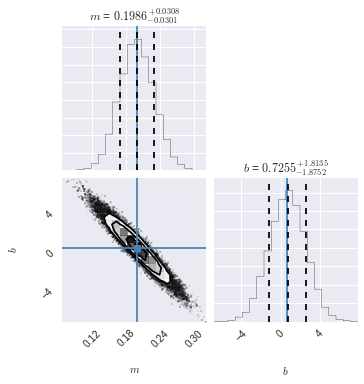

In [1811]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [1, 1], args=(x, y))
m_ml, b_ml= result["x"]
ndim, nwalkers = 2, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y))
sampler.run_mcmc(pos, 1000);
samplesli = sampler.chain[:, 100:, :].reshape((-1, ndim))
meanestli=samplesli.mean(axis=0)
fig = corner.corner(samplesli, labels=["$m$", "$b$"],
                      truths=[meanestli[0], meanestli[1]], quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

(0, 100)

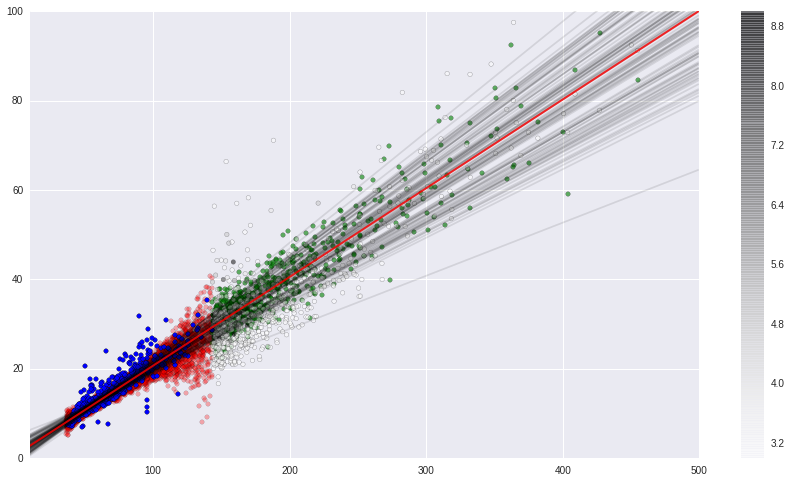

In [1812]:
plt.figure(figsize=(15,8))
xl = np.arange(500)
for m, b in samplesli[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, meanestli[0]*xl+meanestli[1], color="r", lw=2, alpha=0.8)
cutoff=x.max()-0
plt.scatter(xx[xx<cutoff],yy_sim2[xx<cutoff],c='r',alpha=0.3)
AAA=samplesli[np.random.randint(len(samplesli), size=len(xx))]
yy_siml=AAA[:,0]*xx+AAA[:,1]
plt.scatter(xx[xx>cutoff],yy_siml[xx>cutoff],c='g',alpha=0.6)
#plt.scatter(xx[filter],err4mod[(err4mod[:,0]!=0)][:,2][filter],c='k',alpha=0.3)
plt.scatter(xx[xx>cutoff],err4mod[(err4mod[:,0]!=0)][:,2][xx>cutoff],c=err4mod[(err4mod[:,0]!=0)][:,1][xx>cutoff],alpha=0.5)
plt.colorbar()
plt.scatter(x,y)
plt.xlim(10,500)
plt.ylim(0,100)

(0, 100)

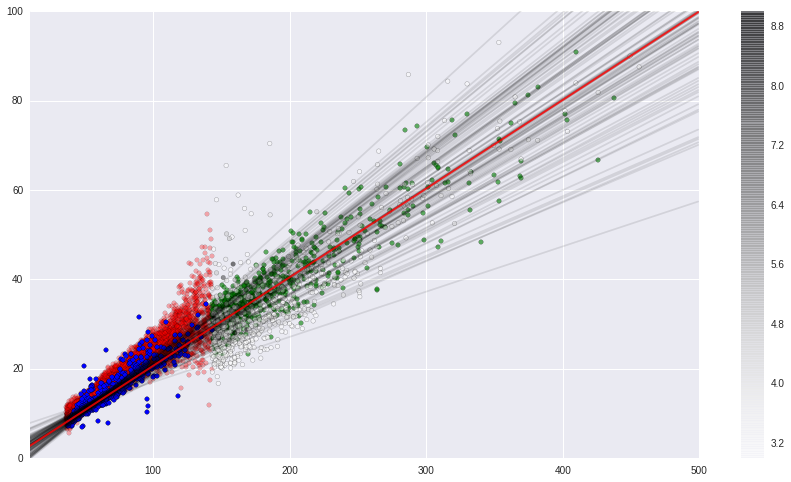

In [1600]:
plt.figure(figsize=(15,8))
xl = np.arange(500)
for m, b in samplesli[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, meanestli[0]*xl+meanestli[1], color="r", lw=2, alpha=0.8)
cutoff=x.max()-0
plt.scatter(xx[xx<cutoff],yy_sim2[xx<cutoff],c='r',alpha=0.3)
AAA=samplesli[np.random.randint(len(samplesli), size=len(xx))]
yy_siml=AAA[:,0]*xx+AAA[:,1]
plt.scatter(xx[xx>cutoff],yy_siml[xx>cutoff],c='g',alpha=0.6)
#plt.scatter(xx[filter],err4mod[(err4mod[:,0]!=0)][:,2][filter],c='k',alpha=0.3)
plt.scatter(xx[xx>cutoff],err4mod[(err4mod[:,0]!=0)][:,2][xx>cutoff],c=err4mod[(err4mod[:,0]!=0)][:,1][xx>cutoff],alpha=0.5)
plt.colorbar()
plt.scatter(x,y)
plt.xlim(10,500)
plt.ylim(0,100)

In [1597]:
x.max()

143.17026422275831

# Hasta aquí

In [1512]:
yerr=errlist[(errlist[:,0]!=0)][:,6] # average - pasa el ks-test pero el p-value de discrepancias no
# pasa el ks test (p<0.05 con un draw para cada tres parametros). con tres draw no pasa el ks-test
# con uno o con tres draws a veces predice valores negativos para el error :(
# pidiendo positividad en los parámetros no funciona el mcmc
# se podría re-simular pidiendo positividad en y cuando un dato salga malo?

In [1520]:
yerr=errlist[(errlist[:,0]!=0)][:,8] 
# minimum - pasa el ks-test casi siempre pero su estadística no es chi-2 (p~1) ni con un draw ni con tres draw
# p-value bayesiano no muestra inconsistencia, (con tres draw para tres parametros), p~0.9<0.975 pero a veces genera
# errores negativos
# con un solo draw el p-value bayesiano si muestra inconsistencia
# con un prior pidiendo positividad de los parámetros, no pasamos el ks-test
# pero para tres draws el bayesian p-value es muy bueno p~0.6

In [1521]:
def lnlike(theta, x, y,yerr):
    m ,b,f = theta
    model = m * x +b+f*yerr
    inv_sigma2 = 1.0/((y)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior(theta):
    m, b,f = theta
    if 0 < m < 1 and 0 < b < 5 and 0<f<10:
        return 0.0
    return -np.inf
def lnprob(theta, x, y,yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr)


In [1522]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls,0.5], args=(x, y,yerr))
m_ml, b_ml,f_ml= result["x"]
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y,yerr))
sampler.run_mcmc(pos, 1000);
sampler.chain.shape

(100, 1000, 3)

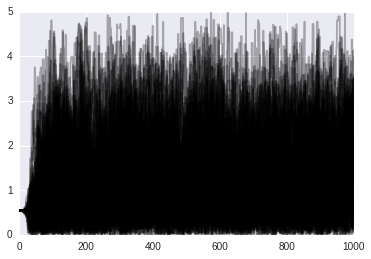

In [1523]:
# b
res=plt.plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)

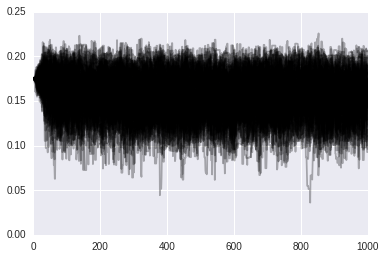

In [1524]:
# m
res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)

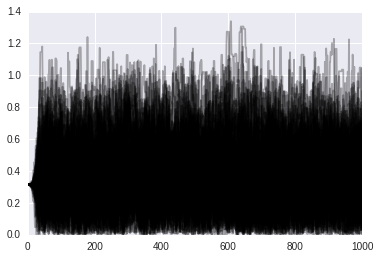

In [1525]:
# f
res=plt.plot(sampler.chain[:,:,2].T, '-', color='k', alpha=0.3)

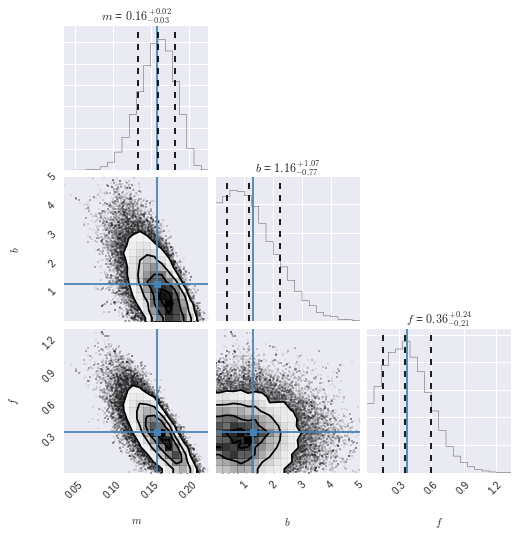

In [1526]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
meanest=samples.mean(axis=0)
fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],
                      truths=[meanest[0], meanest[1],meanest[2]], quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.2f')

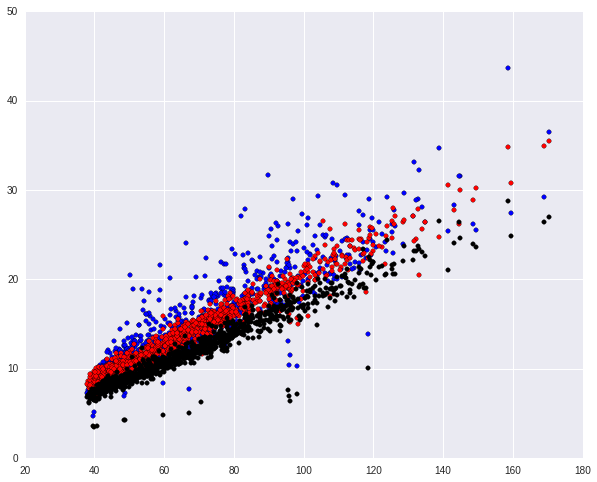

In [1534]:
plt.figure(figsize=(10,8))
AAA=samples[np.random.randint(len(samples), size=len(x))]
plt.scatter(x,y)
plt.scatter(x,AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr,c='r')
plt.scatter(x,errlist[(errlist[:,0]!=0)][:,6],c='k')

In [1540]:
listaksst=[]
listakspv=[]
y_ml=meanest[0]*xl+meanest[1]+meanest[2]*yerrl
rvs1 = (y-y_ml)
ndsets=5000
for i in range(ndsets):
    AAA=samples[np.random.randint(len(samples), size=len(x))]
#    BBB=samples[np.random.randint(len(samples), size=len(x))]
#    CCC=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr
    rvs3 = (y_sim-y_ml)
    listaksst.append(stats.ks_2samp(rvs1, rvs3)[0])
    listakspv.append(stats.ks_2samp(rvs1, rvs3)[1])
listaksst=np.asarray(listaksst)
listakspv=np.asarray(listakspv)
# crit=34.8 for n=25
cpval=-2*(np.log(listakspv)).sum()

In [1541]:
cpval=-2*(np.log(listakspv)).sum()
stats.chi2.cdf(cpval, 2*ndsets)

1.0

(array([   1.,    5.,   27.,  179.,  340.,  266.,  101.,   38.,   11.,    2.]),
 array([-26.24850745, -20.77099309, -15.29347872,  -9.81596436,
         -4.33844999,   1.13906438,   6.61657874,  12.09409311,
         17.57160748,  23.04912184,  28.52663621]),
 <a list of 10 Patch objects>)

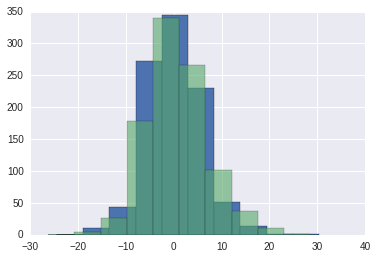

In [1542]:
plt.hist(y_sim-y_ml)
plt.hist(y-y_ml,alpha=0.6)

In [1543]:
(listakspv>0.05).sum()

4944

(array([  104.,   685.,  1398.,  1120.,   958.,   325.,   318.,    51.,
           23.,    18.]),
 array([ 0.02442597,  0.05646347,  0.08850097,  0.12053847,  0.15257597,
         0.18461347,  0.21665096,  0.24868846,  0.28072596,  0.31276346,
         0.34480096]),
 <a list of 10 Patch objects>)

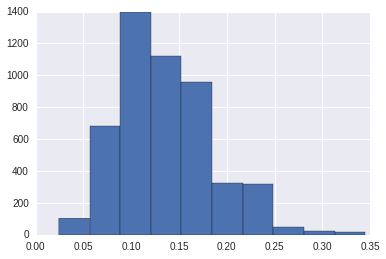

In [1544]:
stats.chi2.cdf(cpval, 2*ndsets)
plt.hist(listakspv)

(0, 35)

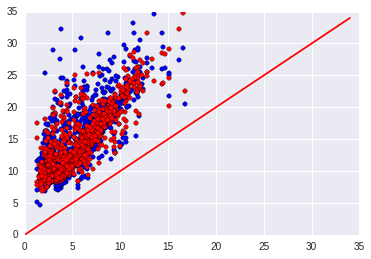

In [1548]:
# gmm-fitted sigma vs reported error
AAA=samples[np.random.randint(len(samples), size=len(x))]

xx=errlist[(errlist[:,0]!=0)][:,8][filter]
yy=errlist[(errlist[:,0]!=0)][:,2][filter]
plt.scatter(xx,yy)
plt.scatter(xx,AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr,c='r')
aaa=35
plt.plot(range(aaa),range(aaa),c='r')
plt.xlim(0,aaa)
plt.ylim(0,aaa)

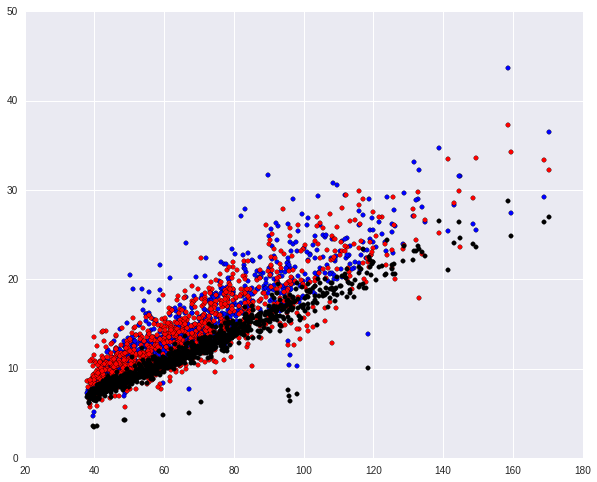

In [1506]:
plt.figure(figsize=(10,8))
AAA=samples[np.random.randint(len(samples), size=len(x))]
BBB=samples[np.random.randint(len(samples), size=len(x))]
CCC=samples[np.random.randint(len(samples), size=len(x))]
plt.scatter(x,y)
plt.scatter(x,AAA[:,0]*x+BBB[:,1]+CCC[:,2]*yerr,c='r')

plt.scatter(x,errlist[(errlist[:,0]!=0)][:,6],c='k')

In [1507]:
discobs=[]
discsim=[]
for m,b,f in samples[np.random.randint(len(samples), size=50000)]:
    b=samples[np.random.randint(len(samples), size=1)][:,1]
    f=samples[np.random.randint(len(samples), size=1)][:,2]
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    BBB=samples[np.random.randint(len(samples), size=len(x))]
    CCC=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+BBB[:,1]+CCC[:,2]*yerr
    yexp=m*x+b+f*yerr
    discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
    discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)

In [1508]:
np.isnan(discsim).sum()

0

0.63602


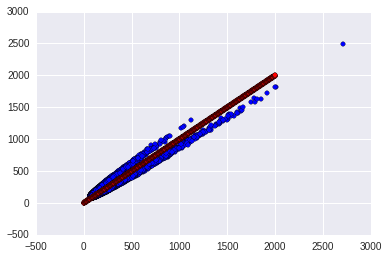

In [1511]:
plt.scatter(discobs,discsim)
print (discobs<discsim).sum()*1./(len(discobs)-np.isnan(discsim).sum())
ppp=np.arange(2000)
plt.scatter(ppp,ppp,c='r')

In [1556]:
discobs=[]
discsim=[]
for m,b,f in samples[np.random.randint(len(samples), size=50000)]:
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr
    yexp=m*x+b+f*yerr
    discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
    discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)

In [1557]:
np.isnan(discsim).sum()

0

0.0


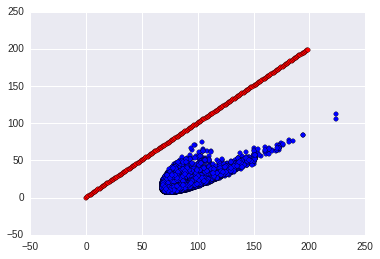

In [1559]:
plt.scatter(discobs,discsim)
print (discobs<discsim).sum()*1./len(discobs)
ppp=np.arange(200)
plt.scatter(ppp,ppp,c='r')

In [1064]:
%%time
from scipy.optimize import curve_fit

hist, bin_edges = np.histogram(data, density=True,bins=nbins)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
p0 = [hist.max(), data.mean(), data.std()]
coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
hist_fit = gauss(bin_centres, *coeff)
print 'Fitted mean = ', coeff[1]/1e6
print 'Fitted standard deviation = ', coeff[2]/1e6
plt.show()

Fitted mean =  80.2544179399
Fitted standard deviation =  18.4722080092
CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 134 ms


0.194389612048 0.0227160657364


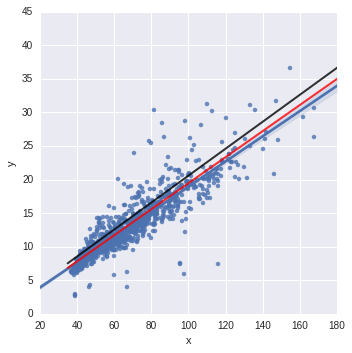

In [50]:
# This is not important, but this could be used for plotting cool-looking error bars
# 16% vs 50%
x=errlist[(errlist[:,0]!=0)][:,3][filter]
y=errlist[(errlist[:,0]!=0)][:,5][filter]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls], args=(x, y))
m_ml, b_ml= result["x"]
print m_ml,b_ml
xl = np.array([35, 200])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="k", lw=2, alpha=0.8)

0.201641440997 2.45550281687


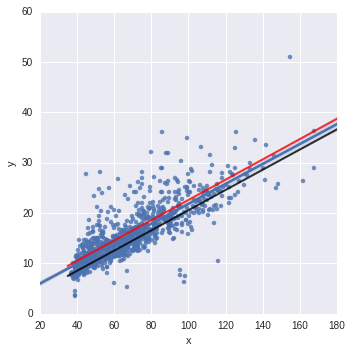

In [51]:
# This is not important
# 84%-16% vs 50%
x=errlist[(errlist[:,0]!=0)][:,3][filter]
y=errlist[(errlist[:,0]!=0)][:,4][filter]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls], args=(x, y))
m_ml, b_ml= result["x"]
print m_ml,b_ml
xl = np.array([35, 200])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="k", lw=2, alpha=0.8)

https://hflog.wordpress.com/2014/04/01/how-to-perform-a-chi-squared-goodness-of-fit-test-in-python/